In [1]:
import numpy as np
import re
import matplotlib.pyplot as plt
import pandas as pd
import glob
import os
import time
import joblib
from statistics import median

import pyfinancialdata
import trade_functions
import pandas_techinal_indicators

from envs import SimpleTradingEnvironment
from agent import DQNAgent
from utils import get_scaler

# Auto reload
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


In [2]:
%%javascript
var nb = IPython.notebook;
var kernel = IPython.notebook.kernel;
var command = "NOTEBOOK_FULL_PATH = '" + nb.base_url + nb.notebook_path + "'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [4]:
# A variable for the name of this notebook
notebook_name = os.path.splitext(os.path.basename(NOTEBOOK_FULL_PATH))[0]

In [5]:
price_data = pyfinancialdata.get_multi_year(
    provider='oanda',
    instrument='EUR_USD',
    years=[2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017],
    time_group='6h',
    price_calculation='close',
)

In [6]:
environment_columns = ['price', 'RSI_14', 'ATR_7', 'ADX_7_14']

def add_features(df):
    '''
    Adds feature columns to a pandas price data df
    '''
    df.reset_index(inplace=True)
    
    df = pandas_techinal_indicators.relative_strength_index(df, 14)
    df = pandas_techinal_indicators.average_true_range(df, 7)
    df = pandas_techinal_indicators.average_directional_movement_index(df, 7, 14)
    
    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True)
    
    return df

In [7]:
price_data = add_features(price_data.copy())

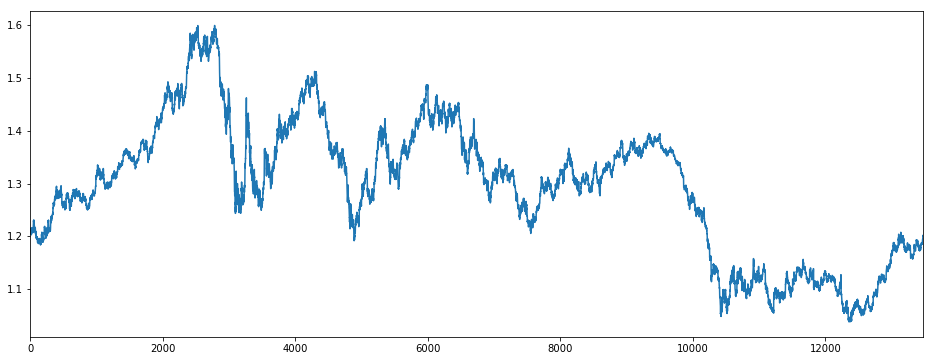

In [8]:
price_data['price'].plot(figsize=(16,6))

In [9]:
train_size = round(len(price_data)/3*2)
train_data = price_data[:train_size].copy()
train_data.reset_index(inplace=True)
test_data = price_data[train_size:].copy()
test_data.reset_index(inplace=True)
print('train size {0}, test size {1}'.format(len(train_data), len(test_data)))

train size 8982, test size 4491


In [10]:
episode=1000
batch_size=10

In [11]:
train_data.head(5)

,index,date,close,high,low,open,price,RSI_14,ATR_7,ADX_7_14
0,0,2006-01-06 12:00:00,1.21538,1.21808,1.20880,1.20938,1.21538,0.838629,0.005064,0.537637
1,1,2006-01-06 18:00:00,1.21520,1.21638,1.21458,1.21538,1.21520,0.838629,0.004246,0.530643
2,2,2006-01-08 18:00:00,1.21420,1.21540,1.21360,1.21540,1.21420,0.781232,0.003633,0.499229
3,3,2006-01-09 00:00:00,1.21460,1.21550,1.21290,1.21410,1.21460,0.739518,0.003375,0.492555
4,4,2006-01-09 06:00:00,1.20752,1.21480,1.20648,1.21460,1.20752,0.472519,0.004612,0.496234


In [12]:
env = SimpleTradingEnvironment(
    price_data=train_data,
    environment_columns=environment_columns,
    debug=False,
    spread=0.00015
)
state_size = env.observation_space.shape
action_size = env.action_space.n
scaler = get_scaler(env)
agent = DQNAgent(state_size, action_size)
train_results = pd.DataFrame()





Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                224       
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 99        
Total params: 1,379
Trainable params: 1,379
Non-trainable params: 0
_________________________________________________________________
None


## Train

In [13]:
for e in range(episode):
    state = env.reset()
    state = scaler.transform([state])
    for i in range(env.n_step):
        action = agent.act(state)
        next_state, reward, done = env.step(action)
        next_state = scaler.transform([next_state])
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        if done:
            print(".", end='')
            if (e + 1) % 20 == 0:
                print("")
                print("episode: {0}/{1}".format(e + 1, episode))
                print("median profit: {0} pips, median trade count: {1}".format(
                    round(median(train_results['account_balance'].tolist()) / 0.0001),
                    round(median(train_results['trade_count'].tolist()))
                    )
                )
            train_results = train_results.append(env._stats(), ignore_index=True)
            break
        if len(agent.memory) > batch_size:
            agent.replay(batch_size)



....................
episode: 20/1000
median profit: -698 pips, median trade count: 727
....

/usr/local/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.108632). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


................
episode: 40/1000
median profit: -92 pips, median trade count: 633
....................
episode: 60/1000
median profit: 1791 pips, median trade count: 593
....................
episode: 80/1000
median profit: 2015 pips, median trade count: 577
....................
episode: 100/1000
median profit: 2203 pips, median trade count: 576
....................
episode: 120/1000
median profit: 2759 pips, median trade count: 586
.............

/usr/local/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.125071). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


.......
episode: 140/1000
median profit: 3086 pips, median trade count: 579
....................
episode: 160/1000
median profit: 2784 pips, median trade count: 579
....................
episode: 180/1000
median profit: 2891 pips, median trade count: 591
....................
episode: 200/1000
median profit: 2871 pips, median trade count: 590
....................
episode: 220/1000
median profit: 3086 pips, median trade count: 593
....................
episode: 240/1000
median profit: 3125 pips, median trade count: 595
....................
episode: 260/1000
median profit: 3143 pips, median trade count: 595
....................
episode: 280/1000
median profit: 3292 pips, median trade count: 595
....................
episode: 300/1000
median profit: 3356 pips, median trade count: 603
....................
episode: 320/1000
median profit: 3592 pips, median trade count: 605
....................
episode: 340/1000
median profit: 3729 pips, median trade count: 608
....................
episode: 360/

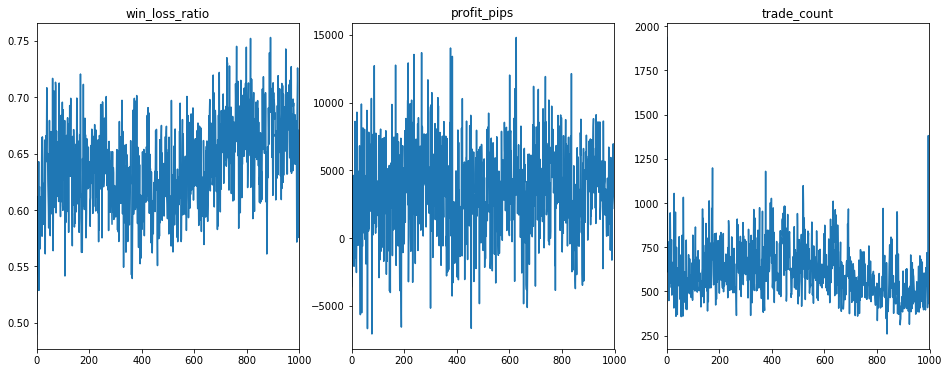

In [14]:
train_results['profit_pips'] = train_results['account_balance'] / 0.0001
columns_to_plot = ['win_loss_ratio', 'profit_pips', 'trade_count']
fig, axes = plt.subplots(nrows=1,ncols=len(columns_to_plot), figsize=(16,6))
for i in range(len(columns_to_plot)):
    axes[i].title.set_text(columns_to_plot[i])
    train_results[columns_to_plot[i]].plot(ax=axes[i], subplots=True)
plt.show()

In [15]:
joblib.dump(agent, '{0}.pkl'.format(notebook_name)) 

['6h-EUR_USD.pkl']

## Test

In [16]:
# Uncomment to load agent from file 
# agent = joblib.load('{0}.pkl'.format(notebook_name))  

In [17]:
# remake the env with test data
env = SimpleTradingEnvironment(
    price_data=test_data,
    environment_columns=environment_columns,
    spread=0.00015
)
state_size = env.observation_space.shape
action_size = env.action_space.n
scaler = get_scaler(env)
test_results = pd.DataFrame()

In [18]:
for e in range(1000):
    state = env.reset()
    state = scaler.transform([state])
    for i in range(env.n_step):
        action = agent.act(state)
        next_state, reward, done = env.step(action)
        next_state = scaler.transform([next_state])
        state = next_state
        if done:
            test_results = test_results.append(env._stats(), ignore_index=True)
            break

In [19]:
test_results['account_balance_pips'] = test_results['account_balance'] / 0.0001
print('Median profit: {0} pips'.format(test_results['account_balance_pips'].median()))

Median profit: 2287.1749999998365 pips


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12c9989d0>]],
      dtype=object)

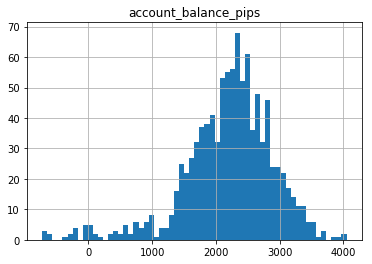

In [20]:
plt.figure(figsize=(16,6))
test_results.hist(column='account_balance_pips', bins=60)

## Analyse positions on test data

In [21]:
# remake the env with test data
env = SimpleTradingEnvironment(
    price_data=test_data.copy(),
    environment_columns=environment_columns,
    save_positions_on_df=True,
    spread=0.00015
)
state_size = env.observation_space.shape
action_size = env.action_space.n

In [22]:
state = env.reset()
state = scaler.transform([state])
for i in range(env.n_step):
    action = agent.act(state)
    next_state, reward, done = env.step(action)
    next_state = scaler.transform([next_state])
    state = next_state
    if done:
        break

In [23]:
env._stats()

{'trade_count': 291,
 'win_loss_ratio': 0.6838487972508591,
 'account_balance': 0.24693499999998414,
 'unrealised_pl': -0.02142500000000025}

In [24]:
position_data = env.price_data.copy()

In [25]:
position_data['position'] = position_data['position'] - 1

In [26]:
trades = trade_functions.create_trades_from_positions(position_data.copy())

293 positions to plot...


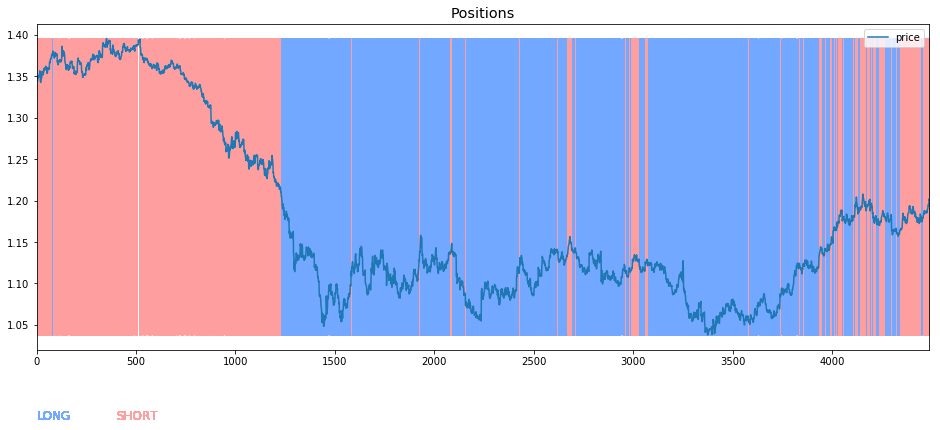

In [27]:
trade_functions.show_positions_on_price_plot(position_data.copy())

In [28]:
trade_functions.get_trade_statistics(trades.copy())

Profitable: 68.94%
Ratio of long to short positions: 0.64
Median profit: 0.0
Total profit: 0.2474099999999977
Median position length: 4.0
Number of trades: 293


In [29]:
trades

,enter_date,enter_price,exit_date,exit_price,position_length,position,profit,profitable,account_balance
0,2013-11-14 00:00:00,1.34706,2013-11-14 06:00:00,1.34330,1,NaN,NaN,False,NaN
1,2013-11-14 06:00:00,1.34330,2013-11-20 18:00:00,1.34306,19,-1.0,0.00024,True,0.00024
2,2013-11-21 00:00:00,1.34238,2013-12-11 00:00:00,1.37577,59,-1.0,-0.03339,False,-0.03315
3,2013-12-11 00:00:00,1.37577,2013-12-11 06:00:00,1.37662,1,1.0,0.00085,True,-0.03230
4,2013-12-11 06:00:00,1.37662,2013-12-11 12:00:00,1.38026,1,-1.0,-0.00364,False,-0.03594
...,...,...,...,...,...,...,...,...,...
288,2017-12-14 00:00:00,1.18268,2017-12-14 18:00:00,1.17749,3,-1.0,0.00519,True,0.26429
289,2017-12-14 18:00:00,1.17749,2017-12-15 12:00:00,1.17649,3,1.0,-0.00100,False,0.26329
290,2017-12-15 12:00:00,1.17649,2017-12-15 18:00:00,1.17503,1,-1.0,0.00146,True,0.26475
291,2017-12-15 18:00:00,1.17503,2017-12-18 12:00:00,1.17904,4,1.0,0.00401,True,0.26876


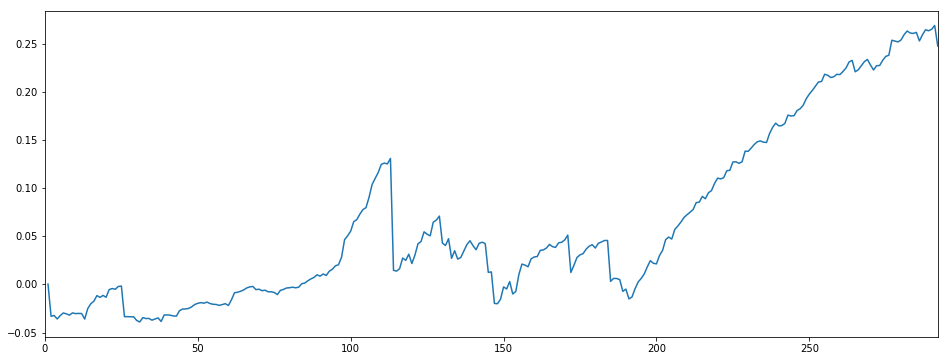

In [30]:
# Plot account balance
trades['account_balance'].plot(figsize=(16,6))

## Show distribution of maximum drawdown

Median drawdown: -0.14103500000000024


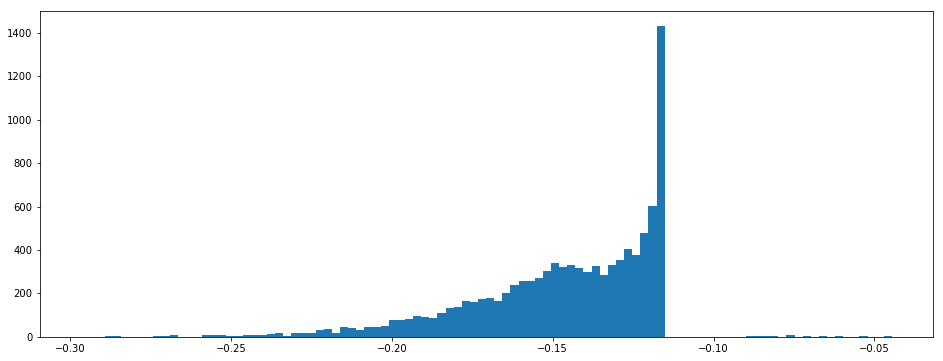

In [31]:
max_drawdown_results = trade_functions.plot_max_drawdown_distribution(trades.copy())
plt.figure(figsize=(16,6))
plt.hist(max_drawdown_results, bins=100);

In [ ]:
}